# Survey statistics

In [7]:
from db import query
from dr_downloader import survey_years
import matplotlib.pyplot as plt
import scienceplots
import pandas as pd
from astropy.time import Time

plt.style.use('science')

filters = ['g', 'r', 'i', 'z']
filter_colors = {'g': '#008060', 'r': '#ff4000', 'i': '#850000', 'z': '#6600cc'}
linestyles = {'g': "--", "r":"-.", "i":":", "z":"-"}

In [8]:
years = survey_years() # cache this

catalog_delta = years[0].value[1][0] - years[0].value[0][0] # Time epoch for first year catalog
catalog_dates = []
catalog_dates.append(Time([years[0].value[0][0], \
                years[0].value[1][0]], format="mjd"))

for i in range(1, 8):
    catalog_dates.append(Time([years[0].value[0][0], \
                years[0].value[1][0] + (i)*catalog_delta], format="mjd"))
catalog_dates.append(Time([years[0].value[0][0], \
                years[-1].value[1][0]], format="mjd"))

In [9]:
catalog_detection_counts = []

for date in catalog_dates:
    stmt = f'''
    select count(*)
    from dp03_catalogs_10yr.DiaSource as DiaSource
    where midPointMjdTai >= {date[0]} and midPointMjdTai <= {date[1]}
    '''
    detection_count = query(stmt)
    catalog_detection_counts.append(detection_count["count"])

KeyboardInterrupt: 

Text(0.5, 0, 'Year of survey')

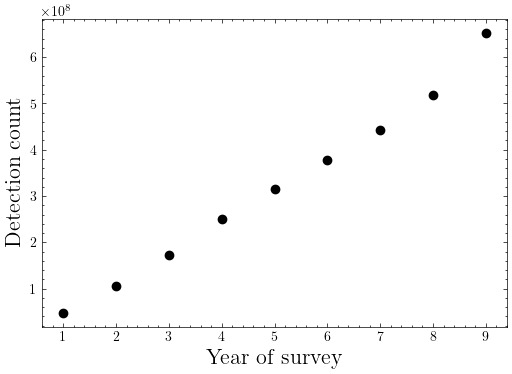

In [ ]:
plt.figure(figsize=(6, 4))

plt.scatter(
    [i for i in range(1,10)],
    catalog_detection_counts,
    c="black"
)
plt.ylabel("Detection count", fontsize=16)
plt.xlabel("Year of survey", fontsize=16)

In [ ]:
yearly_detection_counts = []

for date in catalog_dates:

    stmt = f'''
        select count(*), numObs
        from dp03_catalogs_10yr.DiaSource as DiaSource
        join dp03_catalogs_10yr.SSObject on SSObject.ssObjectId = DiaSource.ssObjectId
        where midPointMjdTai >= {date[0]} and midPointMjdTai <= {date[1]}
        group by numObs
        '''

    yearly_detection_counts.append(query(stmt))

    fig, axs = plt.subplots(1, figsize=(10,8))

for i, year in enumerate(yearly_detection_counts):
    axs.scatter(
        year["numObs"],
        year["count"],
        s=.5,
        label=f"DR{i + 1}"
    )
    
axs.set_xlabel("Number of object observations", fontsize=16)
axs.set_ylabel(r"$N_{obs}$", fontsize=16)
lgnd = plt.legend()

axs.set_ylim()
axs.set_xlim(0, 1000)


(0.0, 1000.0)

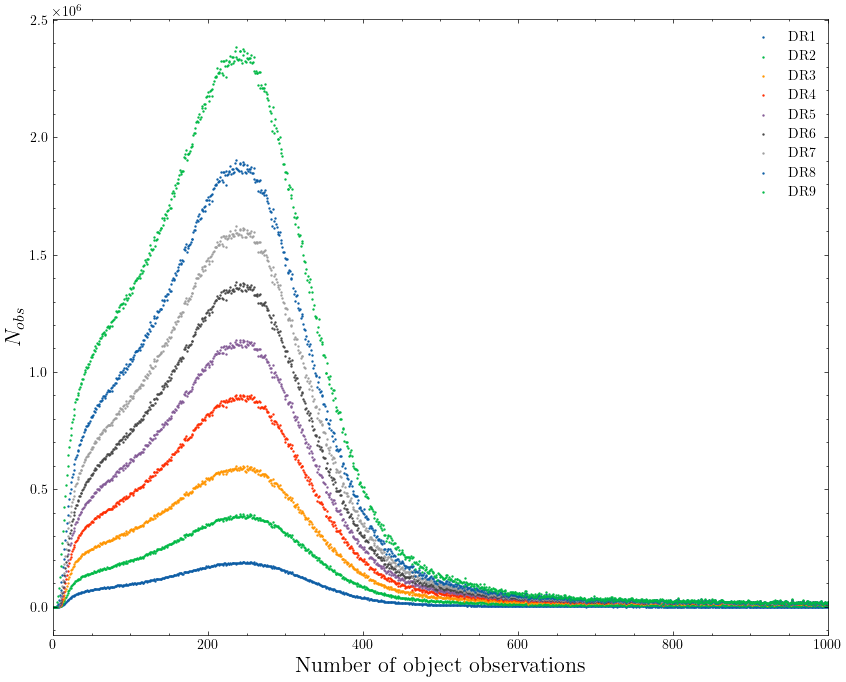

In [ ]:
fig, axs = plt.subplots(1, figsize=(10,8))

for i, year in enumerate(yearly_detection_counts):
    axs.scatter(
        year["numObs"],
        year["count"],
        s=.5,
        label=f"DR{i + 1}"
    )
    
axs.set_xlabel("Number of object observations", fontsize=16)
axs.set_ylabel(r"$N_{obs}$", fontsize=16)
lgnd = plt.legend()

axs.set_ylim()
axs.set_xlim(0, 1000)
# Orbit cuts.


/var/folders/44/yjf9jwgd1bqfct8dx076vwqm0000gn/T/ipykernel_66619/1327460452.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1, figsize=(10,8))


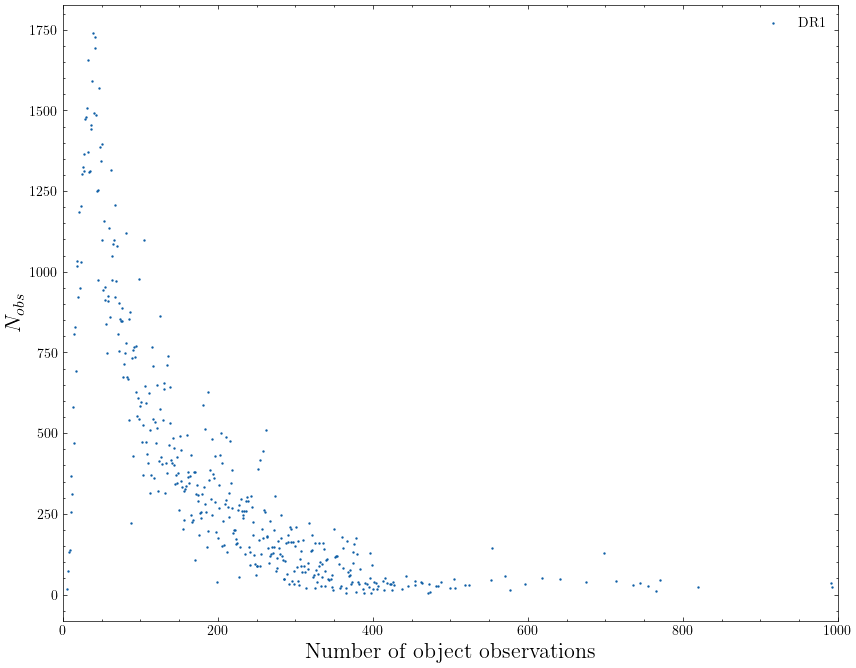

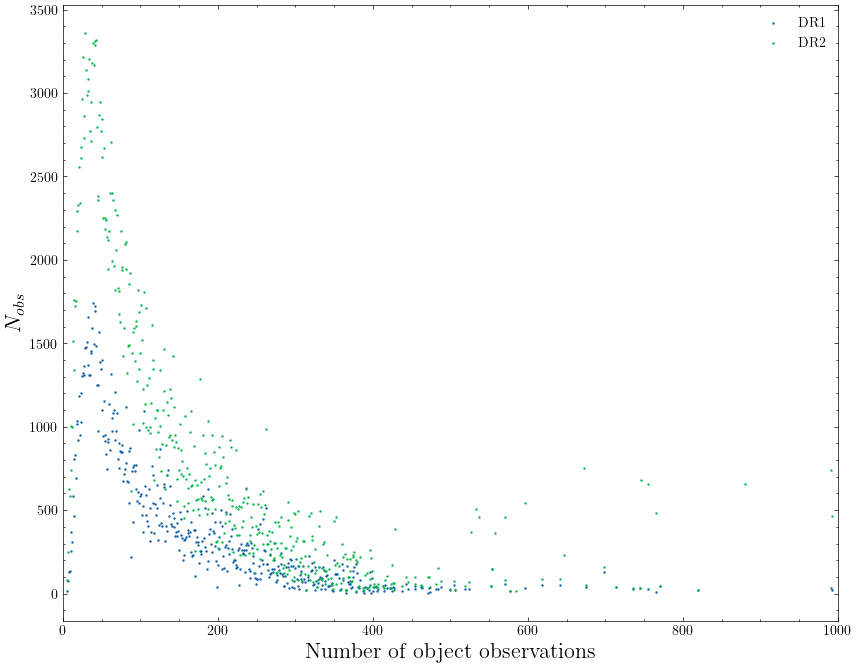

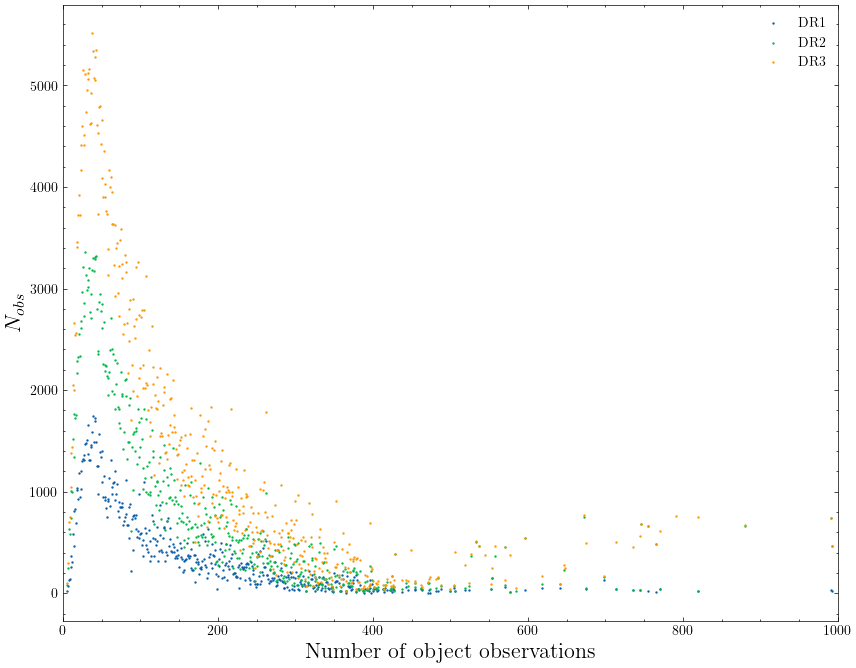

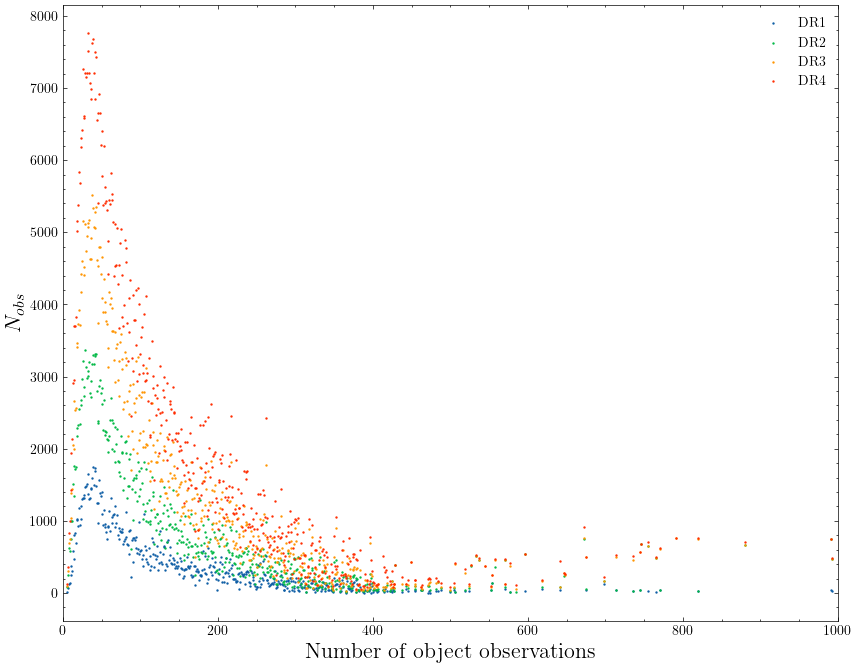

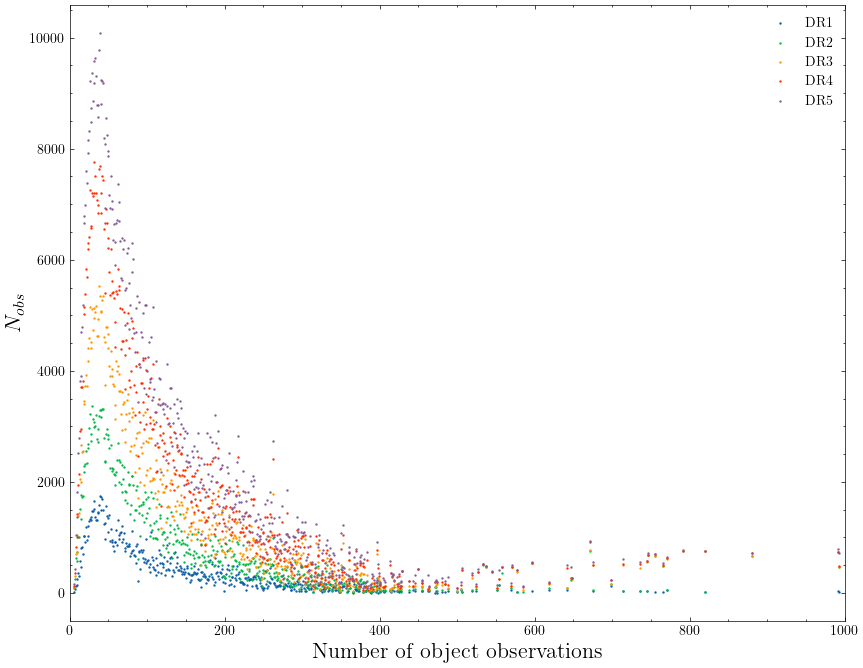

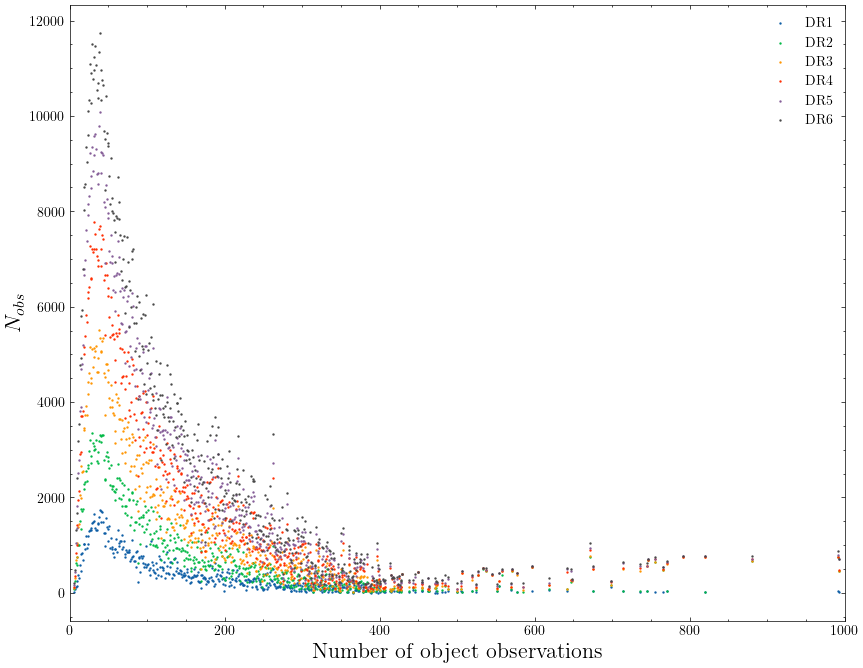

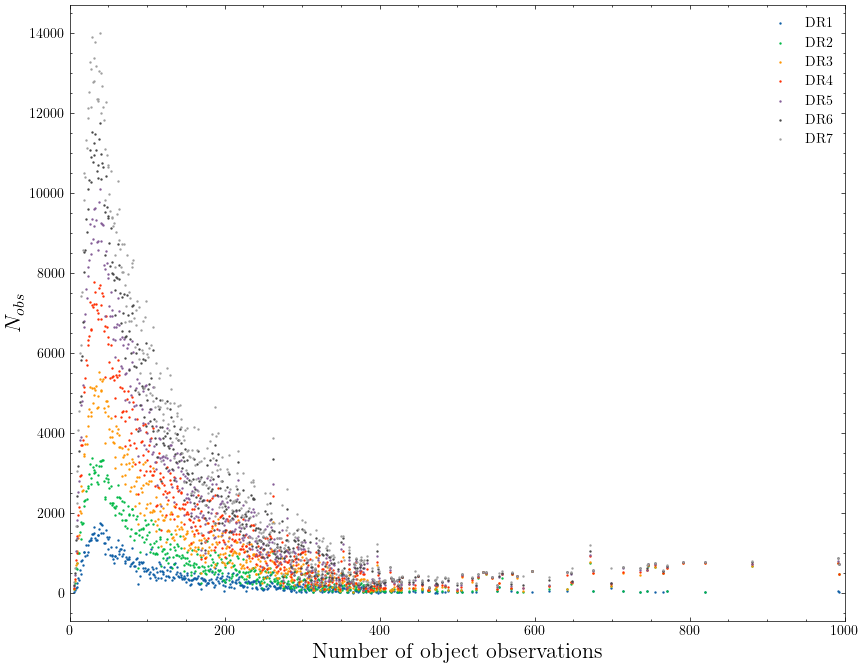

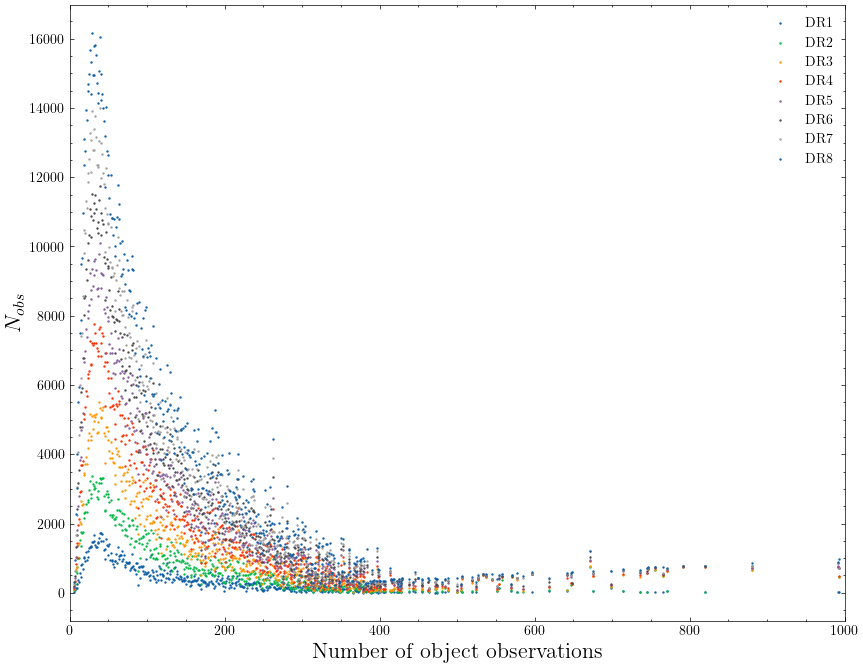

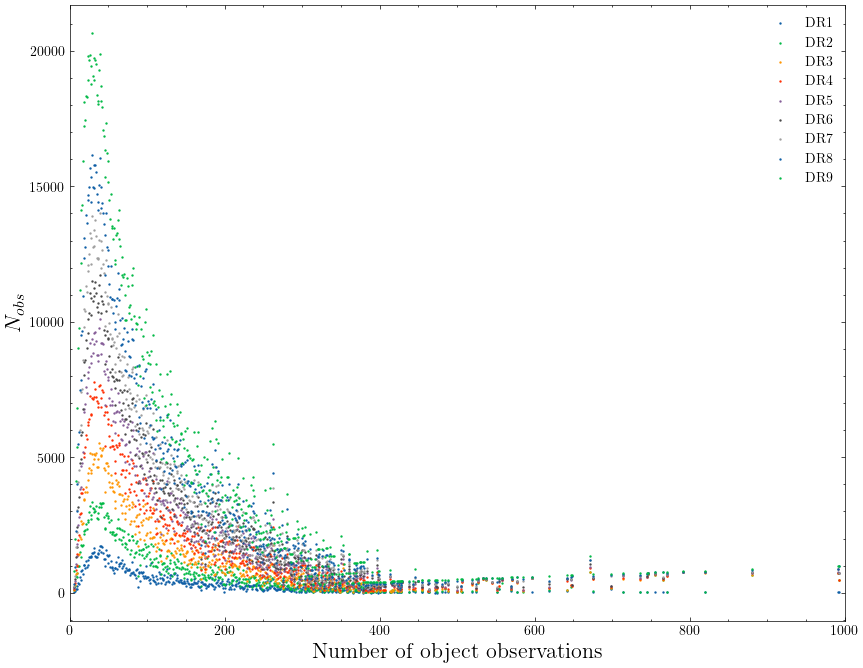

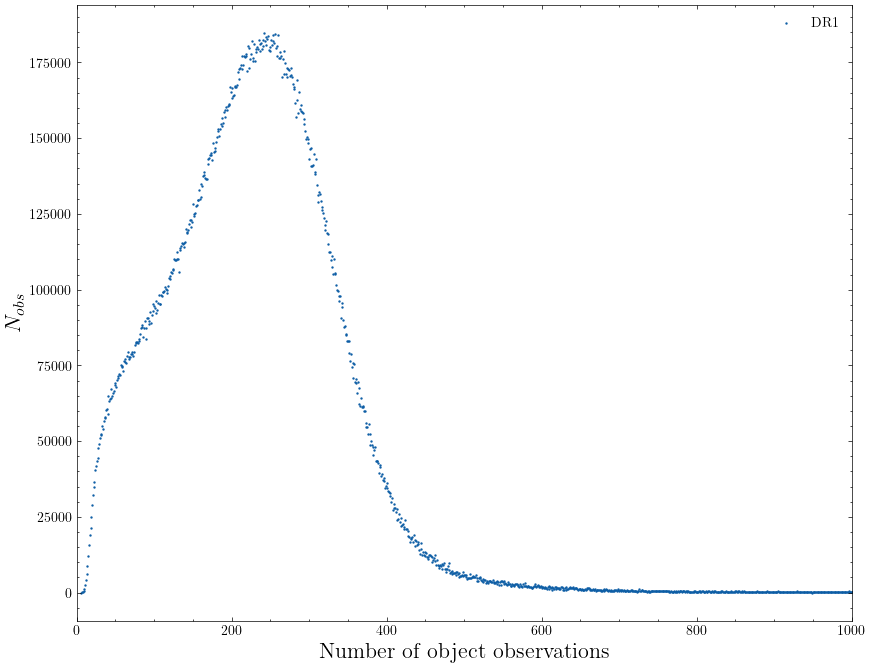

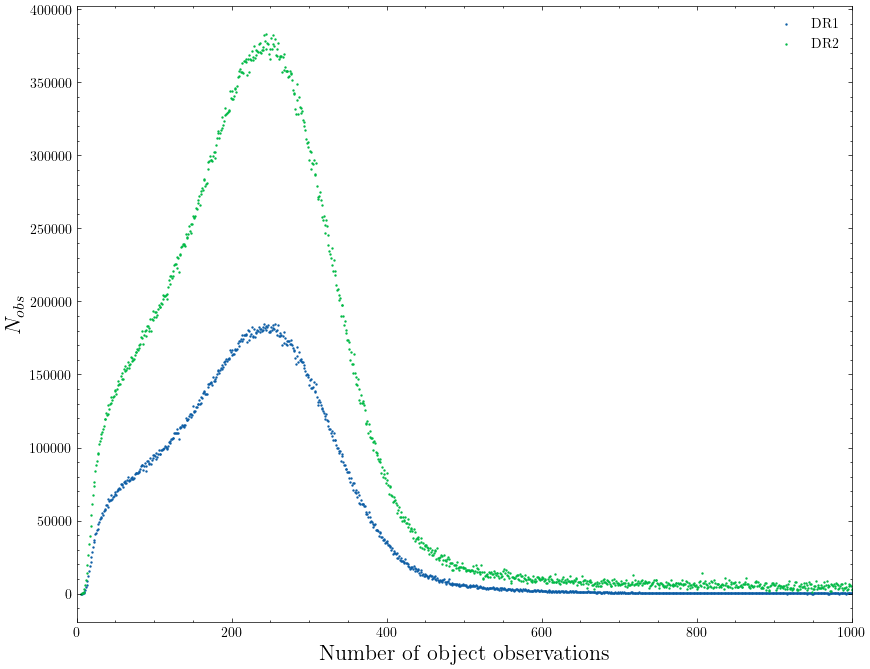

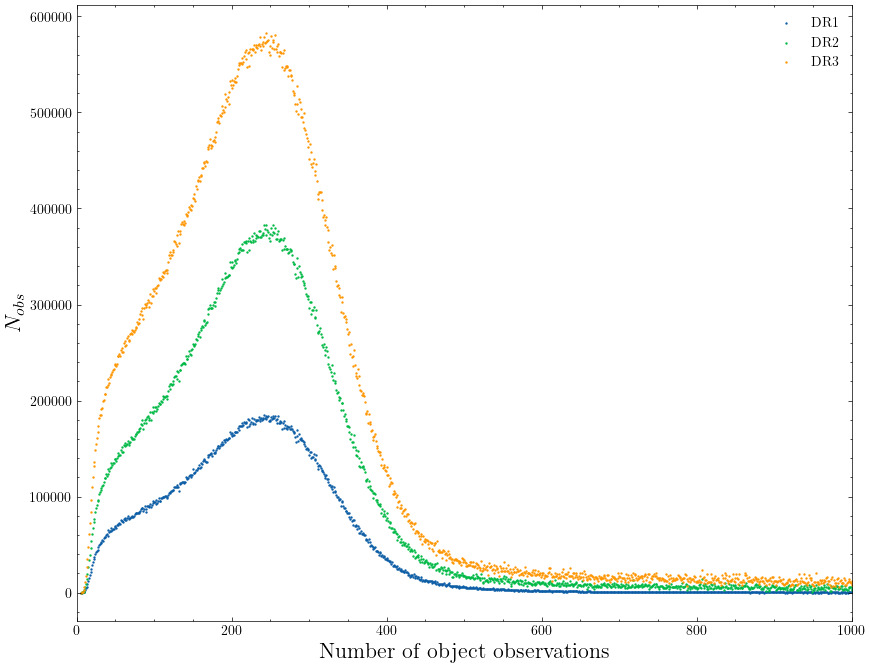

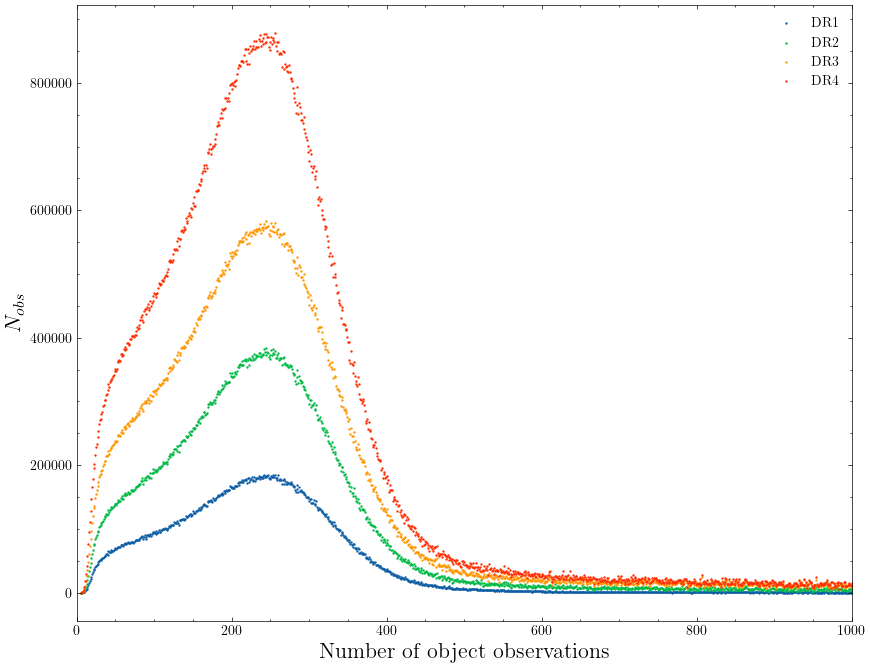

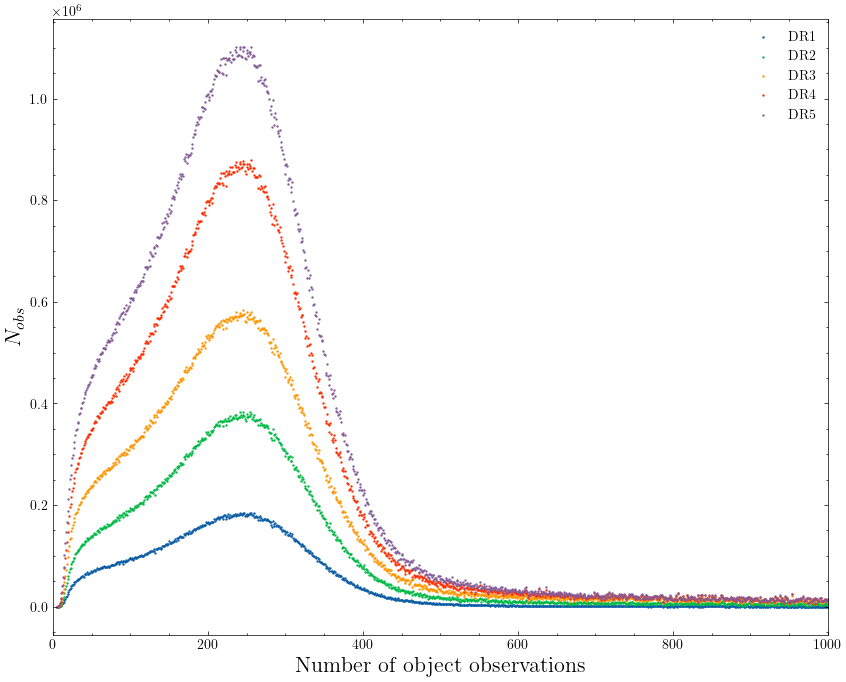

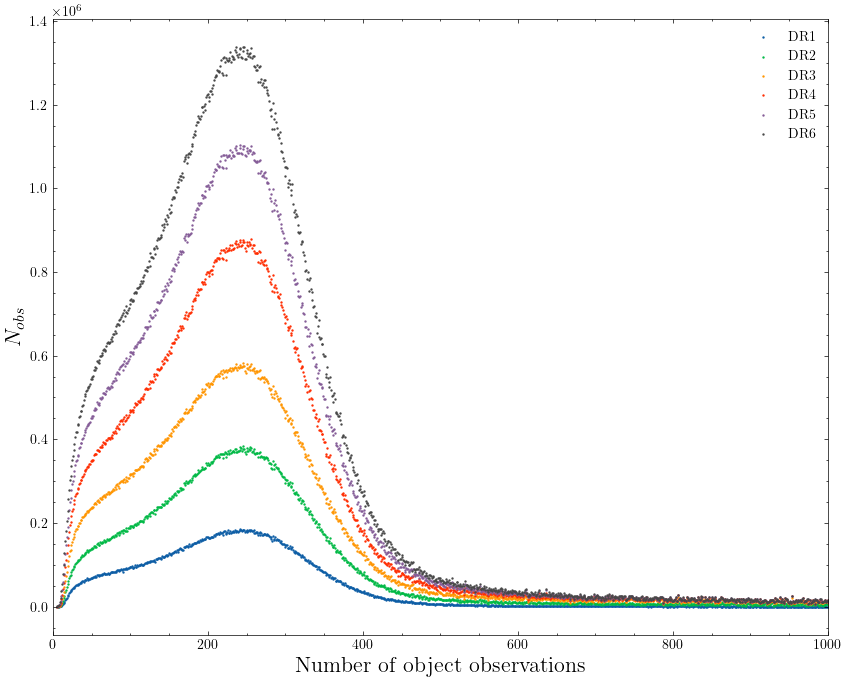

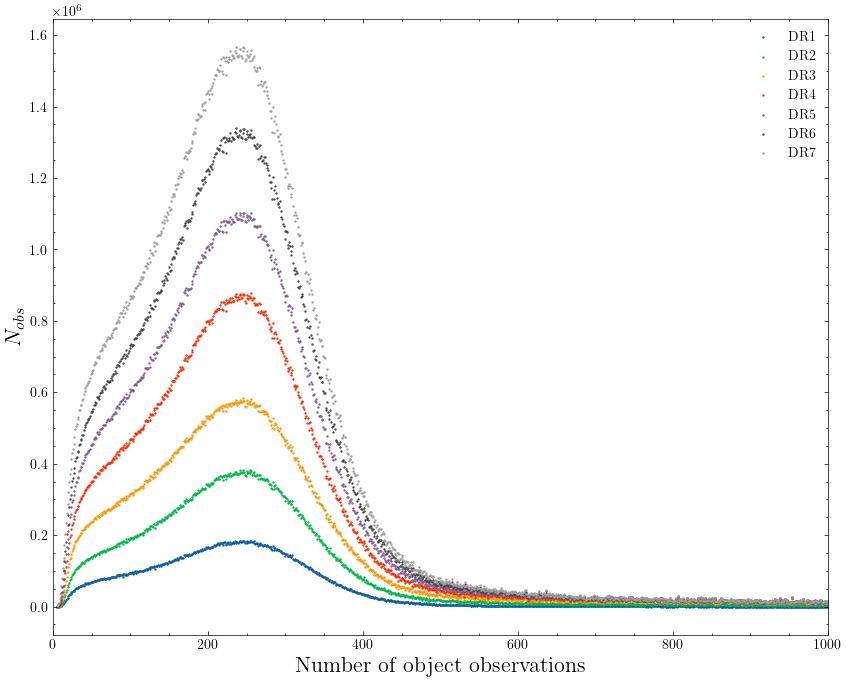

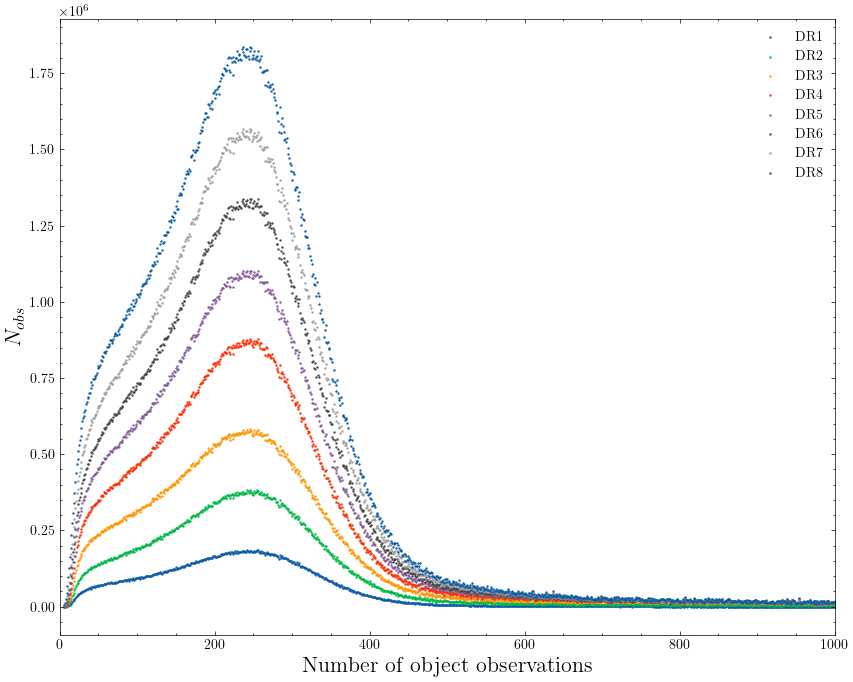

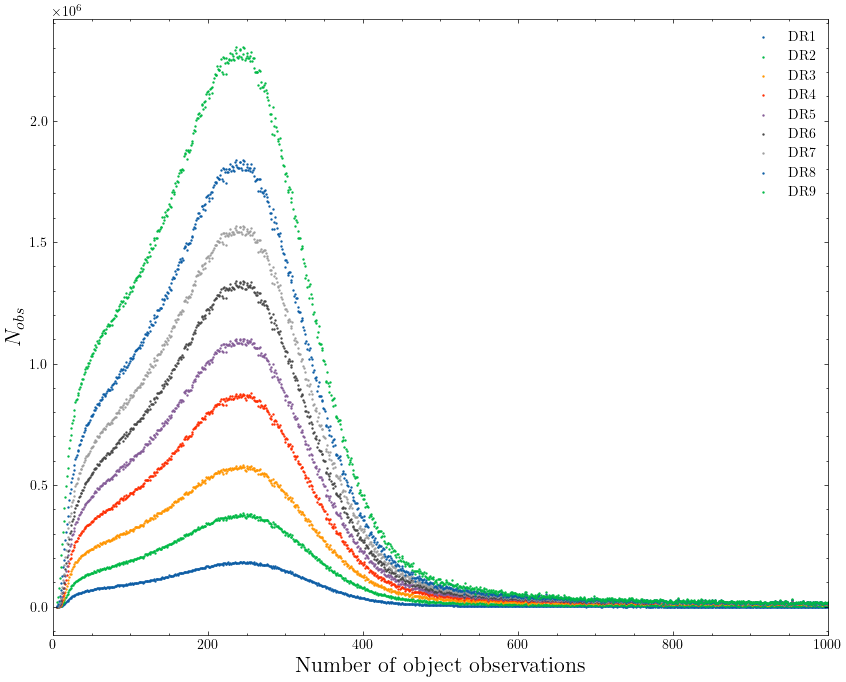

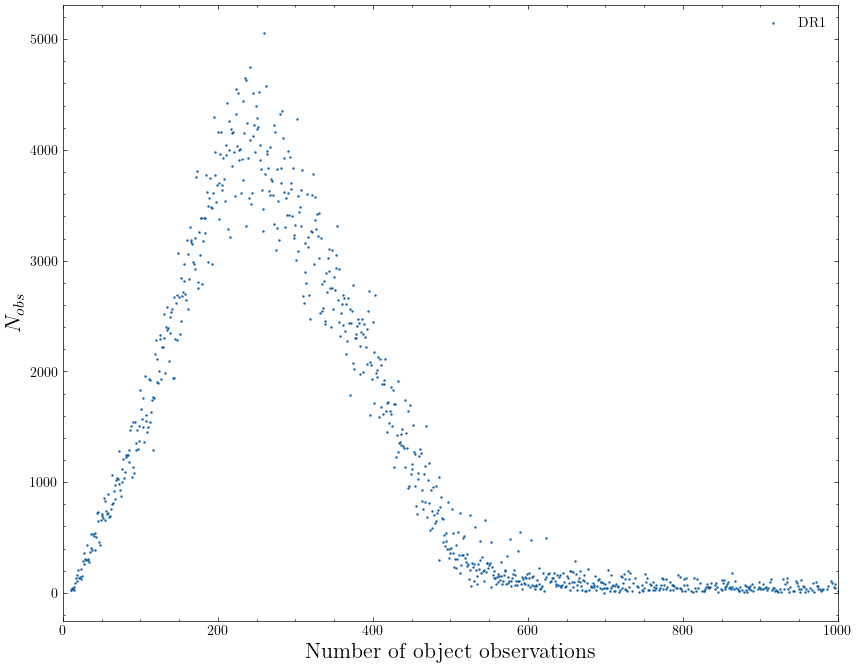

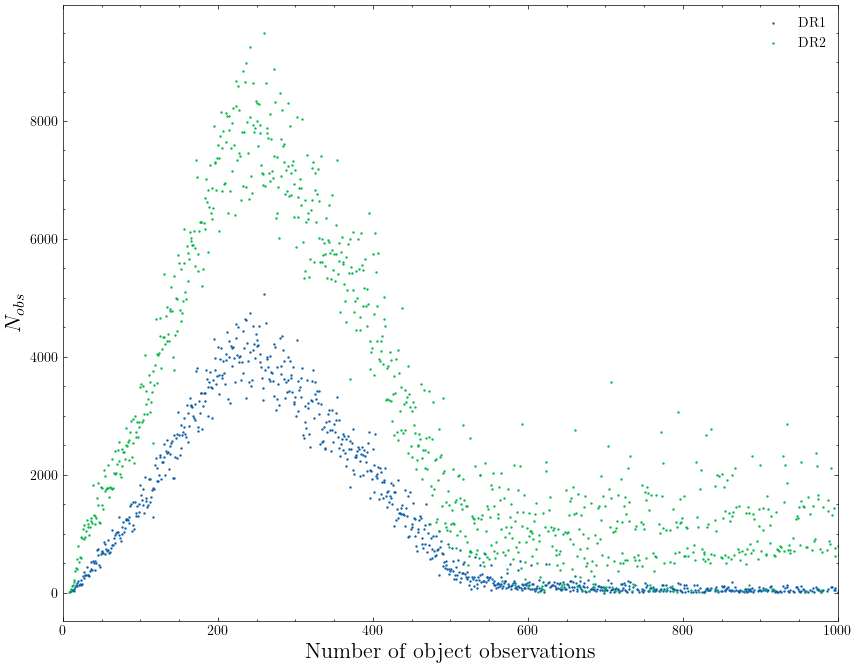

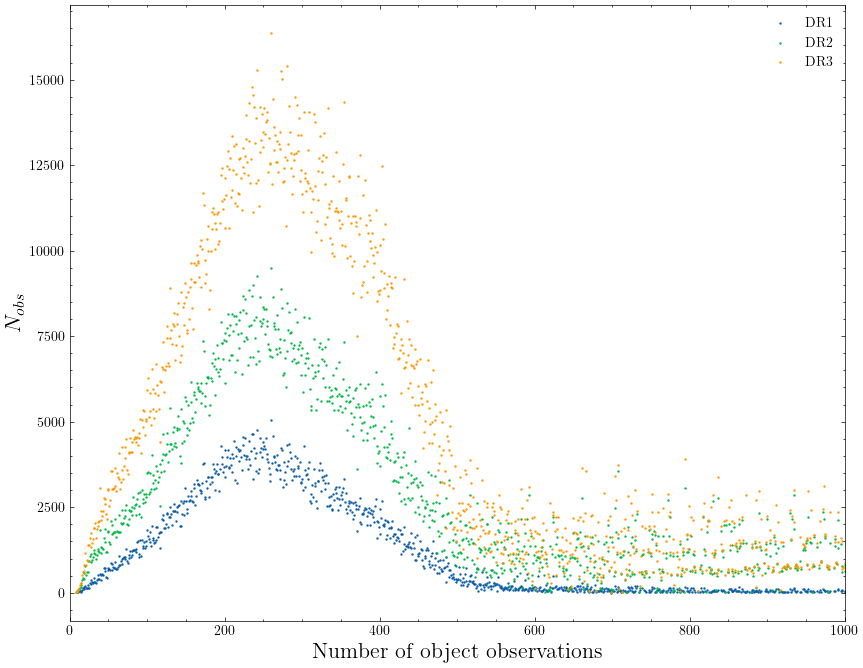

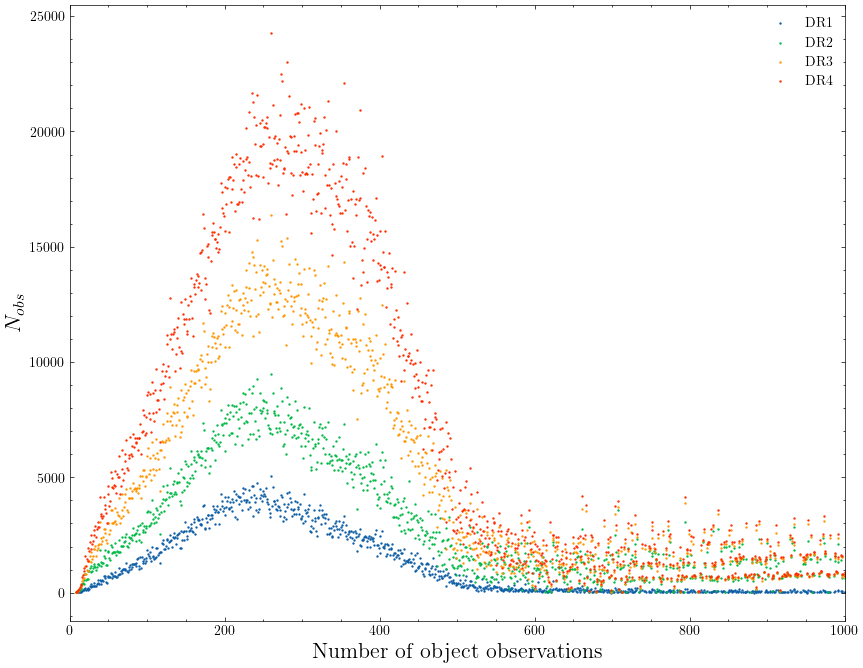

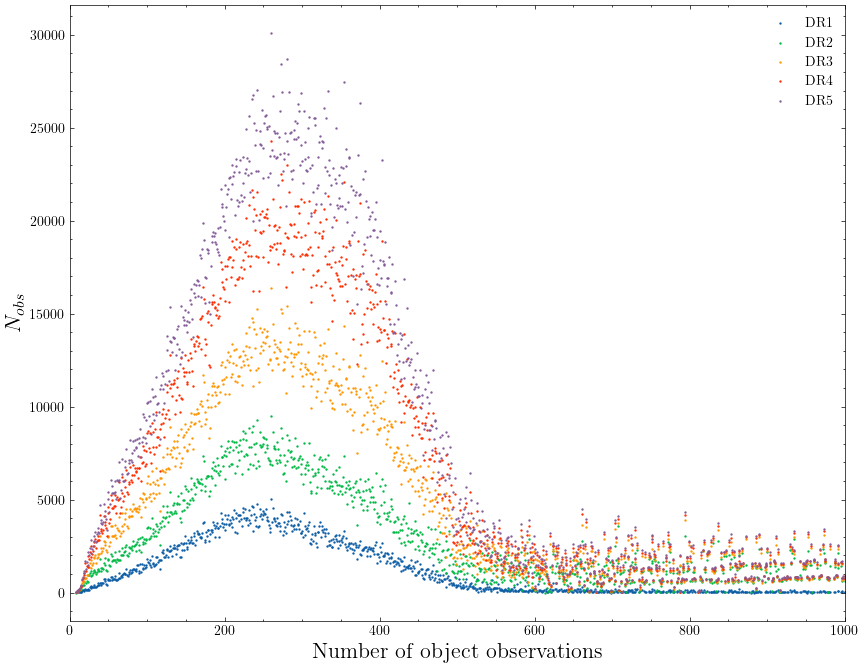

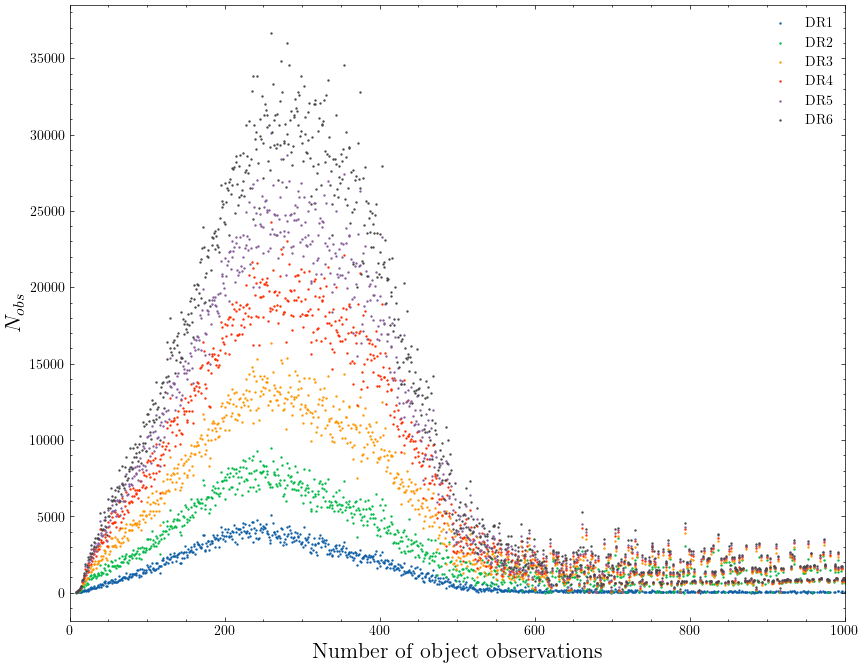

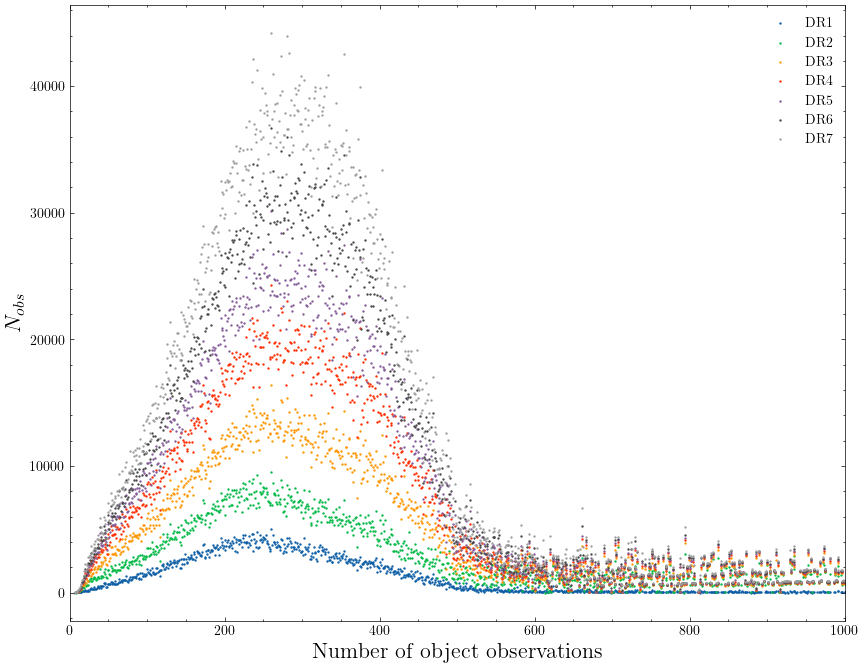

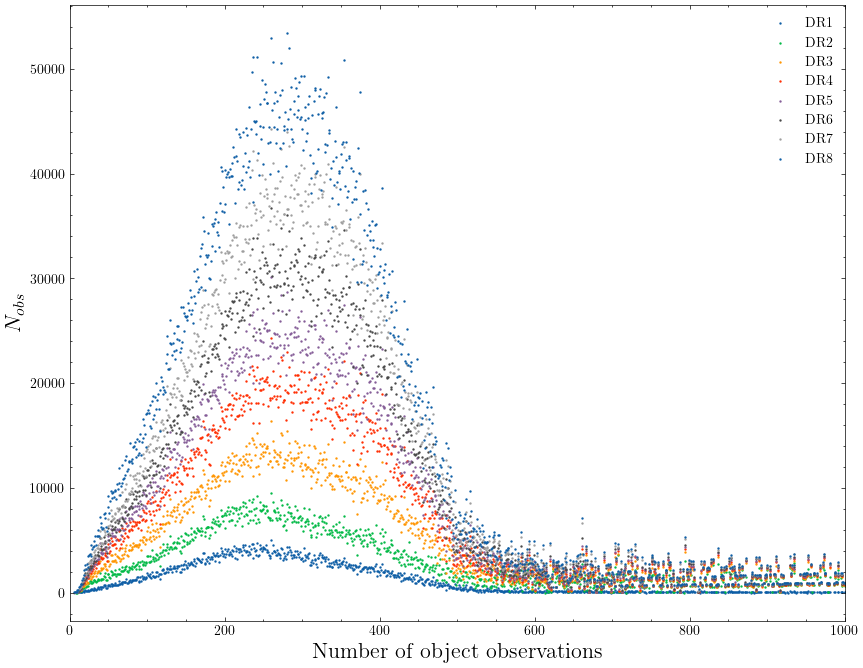

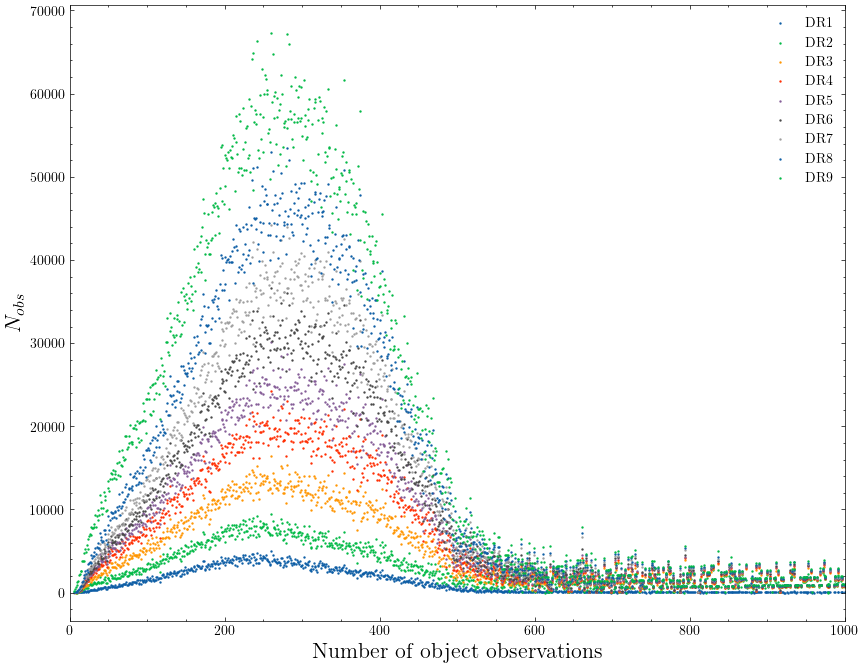

In [19]:
regions = {
    "NEO": "q <= 1.3",
    "Main Belt": "(mpc.e <1) and (mpc.q/(1-mpc.e) >= 1.6) and (mpc.q/(1-mpc.e) <= 4.2 and mpc.q>=1.3)",
    "Jupiter Trojans": "(mpc.q/(1-mpc.e) >= 5.05) and (mpc.q/(1-mpc.e) <= 5.35)" #5.05 and 5.35 AU
}

for region, condition in regions.items():
    yearly_detection_counts = []
    for date in catalog_dates:
        stmt = f'''
            select count(*), numObs
            from dp03_catalogs_10yr.DiaSource as ds
            inner join dp03_catalogs_10yr.SSObject as sso on sso.ssObjectId = ds.ssObjectId
            left outer join dp03_catalogs_10yr.MPCORB as mpc on mpc.ssObjectId = sso.ssObjectId
            where ds.midPointMjdTai >= {date[0]} and ds.midPointMjdTai <= {date[1]} and {condition}
            group by numObs
        '''
        yearly_detection_counts.append(query(stmt))
        fig, axs = plt.subplots(1, figsize=(10,8))
        for i, year in enumerate(yearly_detection_counts):
            axs.scatter(
                year["numObs"],
                year["count"],
                s=.5,
                label=f"DR{i + 1}"
            )
        axs.set_xlabel("Number of object observations", fontsize=16)
        axs.set_ylabel(r"$N_{obs}$", fontsize=16)
        lgnd = plt.legend()
        axs.set_ylim()
        axs.set_xlim(0, 1000)
        plt.savefig(f"{region}_mag_dist.png")

Magnitude versus magnitude error detection density

In [4]:
year = years[0]

magErrDist = {
    "g":[], "r":[], "i":[], "z":[]
}

for filt in filters:
    magErrDist[filt].append(query(
        stmt = f'''
        SELECT mag, magErr
        FROM dp03_catalogs_10yr.DiaSource as DiaSource
        WHERE midPointMjdTai >= {year[0][0]} and midPointMjdTai <= {year[1][0]} and band = '{filt}'
        LIMIT 100000
        '''
    ))

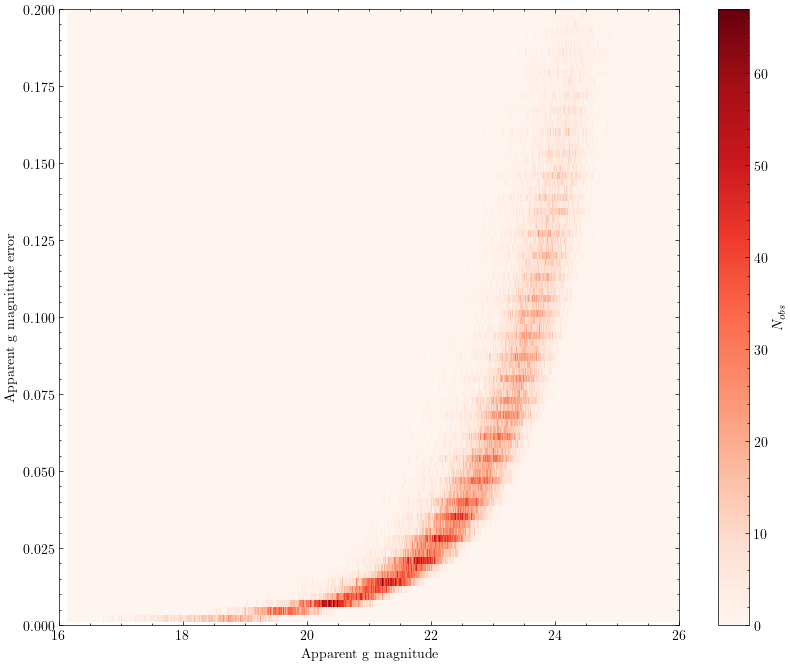

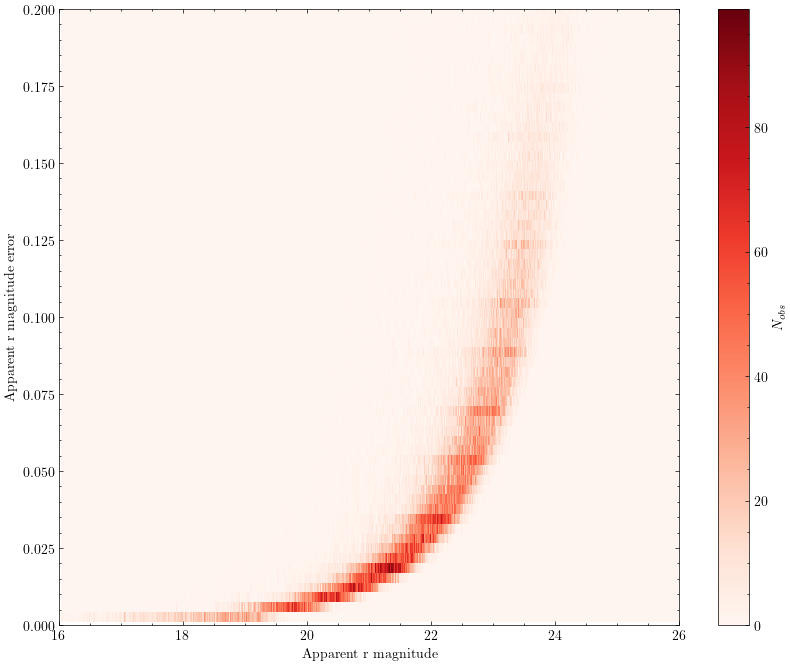

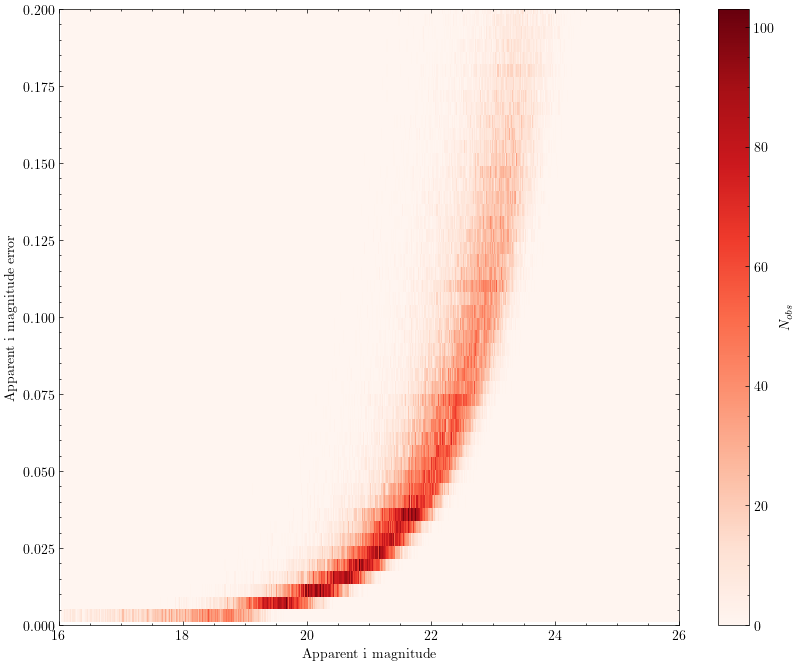

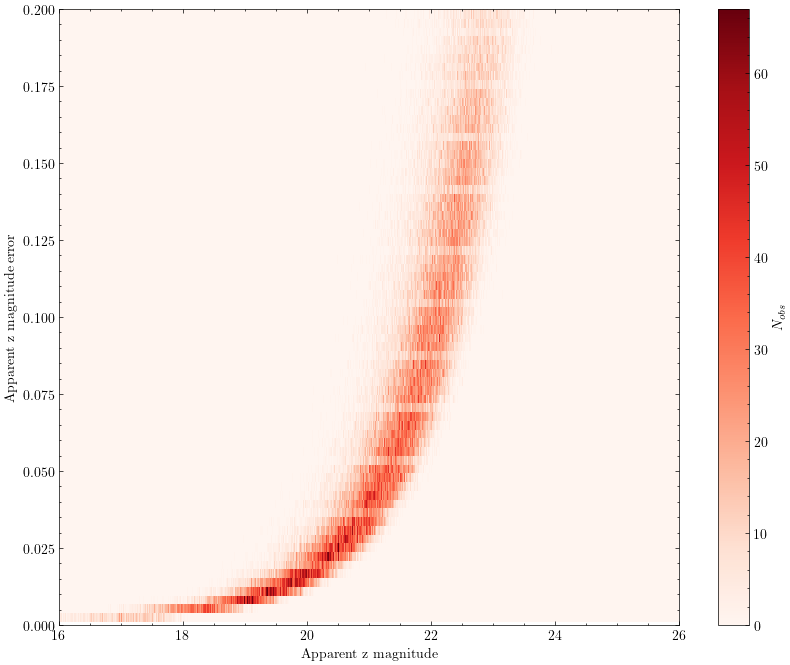

In [ ]:
for filt in filters:
    plt.figure(figsize=(10, 8))
    plt.hist2d(
        magErrDist[filt][0]["mag"],
        magErrDist[filt][0]["magErr"],
        bins=1000,
        cmap=plt.cm.Reds
    )
    plt.colorbar(label=r"$N_{obs}$")
    plt.xlim(16, 26)
    plt.ylim(0, 0.2)
    plt.xlabel(f"Apparent {filt} magnitude")
    plt.ylabel(f"Apparent {filt} magnitude error")
    plt.show()

Magnitude distributions

In [3]:
df = pd.read_csv("apMagBins.csv")
df.describe()

,bin16,bin17,bin18,bin19,bin20,bin21,bin22,bin23,bin24,bin25,...,bin41,bin42,bin43,bin44,bin45,bin46,bin47,bin48,bin49,bin50
count,36.000000,36.000000,36.000000,3.600000e+01,3.600000e+01,3.600000e+01,3.600000e+01,3.600000e+01,3.600000e+01,36.000000,...,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000
mean,52047.444444,155473.055556,412130.638889,9.778629e+05,2.107801e+06,4.085200e+06,5.673239e+06,3.836051e+06,7.038610e+05,59545.222222,...,96.638889,75.861111,57.500000,45.388889,33.111111,27.277778,20.833333,16.250000,11.555556,9.444444
std,29439.573191,83222.466799,216506.618812,5.052945e+05,1.077015e+06,2.057841e+06,3.030586e+06,2.972244e+06,7.220641e+05,35756.466606,...,61.255975,47.119394,35.030191,29.421351,20.626997,16.958118,13.840933,11.043744,7.240538,6.021127
min,6031.000000,31263.000000,87413.000000,2.176480e+05,4.835640e+05,9.845870e+05,1.695783e+06,4.576860e+05,1.744500e+04,2654.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,34116.250000,107202.000000,284382.750000,6.746940e+05,1.451645e+06,2.796720e+06,3.209398e+06,1.960019e+06,1.715952e+05,45918.500000,...,63.000000,49.750000,38.750000,26.250000,19.000000,17.500000,12.500000,8.750000,6.750000,5.750000
50%,55612.000000,166219.000000,436359.000000,1.019309e+06,2.183754e+06,4.237474e+06,5.521382e+06,3.268854e+06,4.851680e+05,55901.000000,...,87.000000,68.000000,52.000000,39.500000,31.500000,25.000000,19.000000,15.500000,11.500000,9.000000
75%,65407.000000,193680.250000,507676.750000,1.205021e+06,2.597834e+06,5.061939e+06,7.277896e+06,5.445390e+06,1.093844e+06,68834.250000,...,132.500000,100.250000,79.000000,64.500000,45.500000,36.750000,28.500000,21.250000,16.500000,11.250000
max,131031.000000,376827.000000,987276.000000,2.316117e+06,4.972236e+06,9.583401e+06,1.470042e+07,1.484207e+07,3.167619e+06,181683.000000,...,258.000000,185.000000,140.000000,112.000000,87.000000,71.000000,64.000000,42.000000,28.000000,26.000000


Yearly magnitude distributions

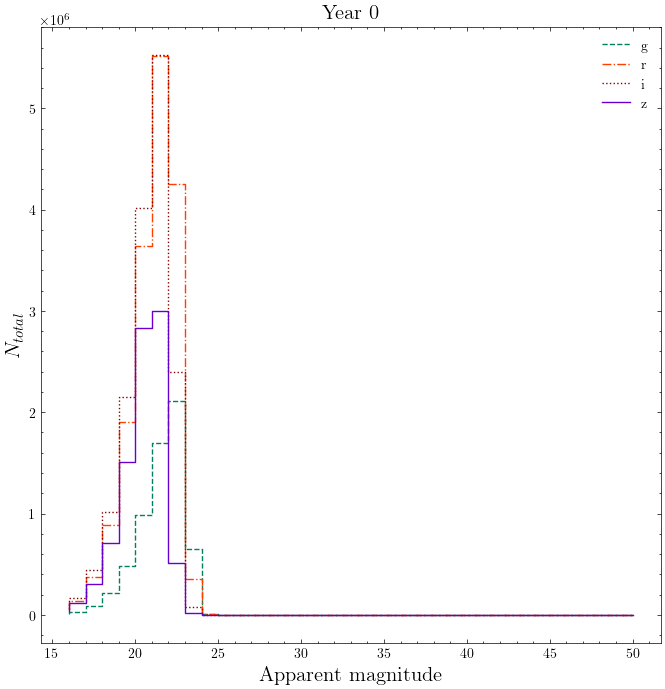

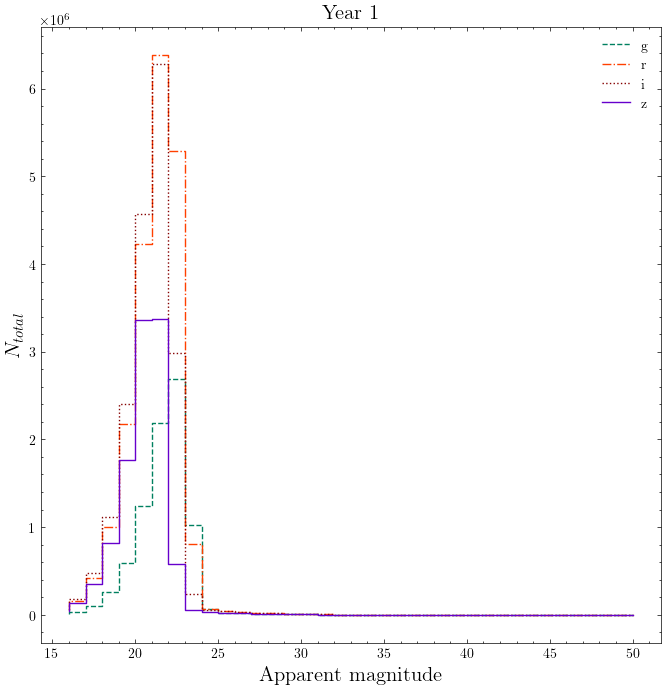

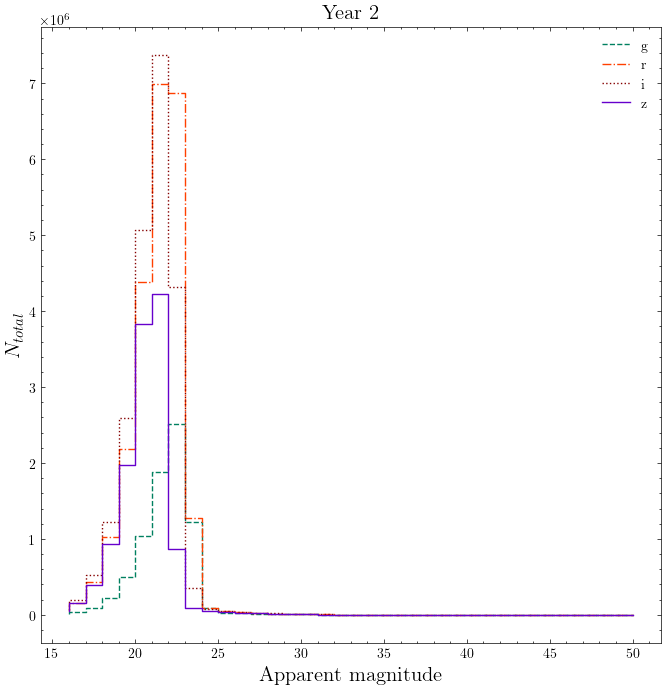

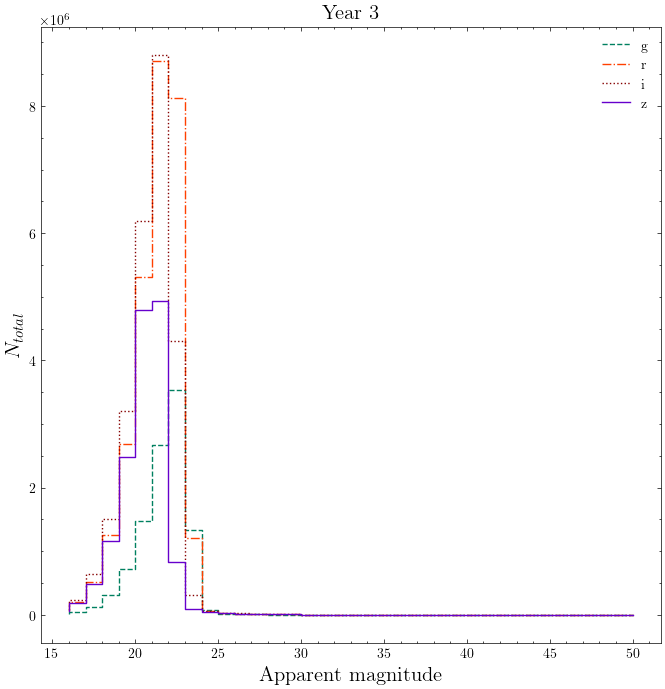

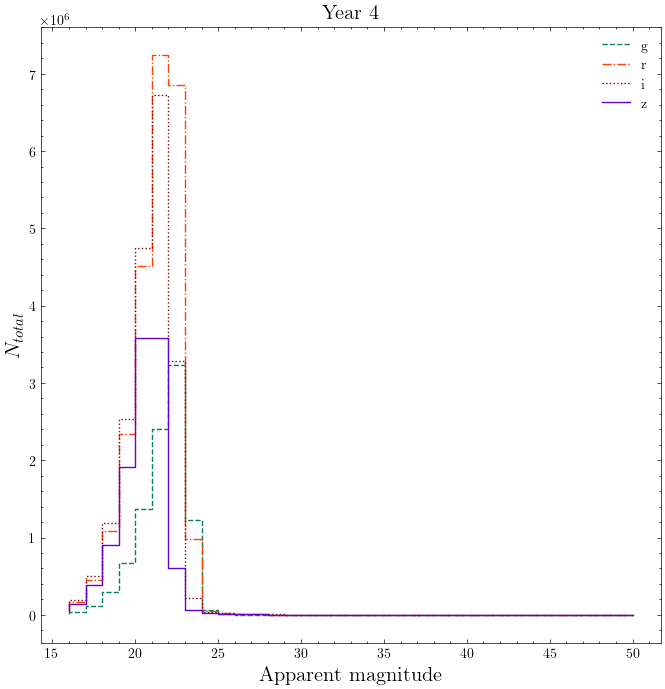

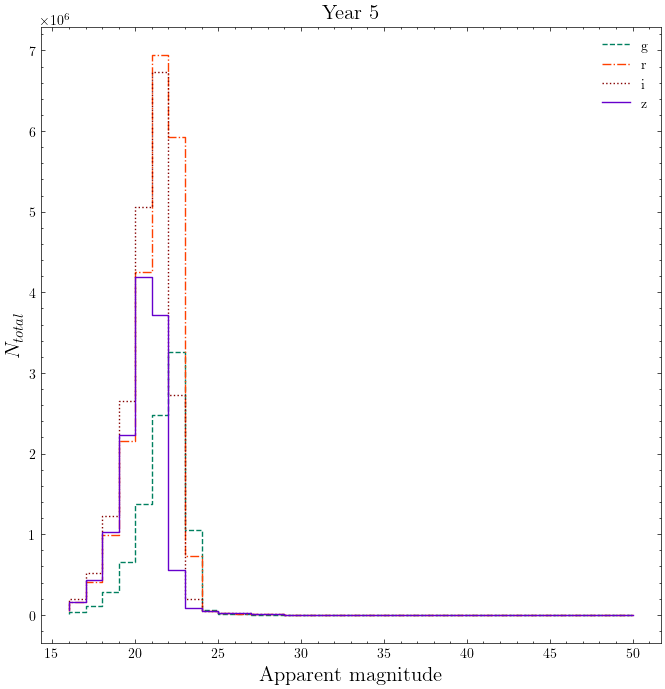

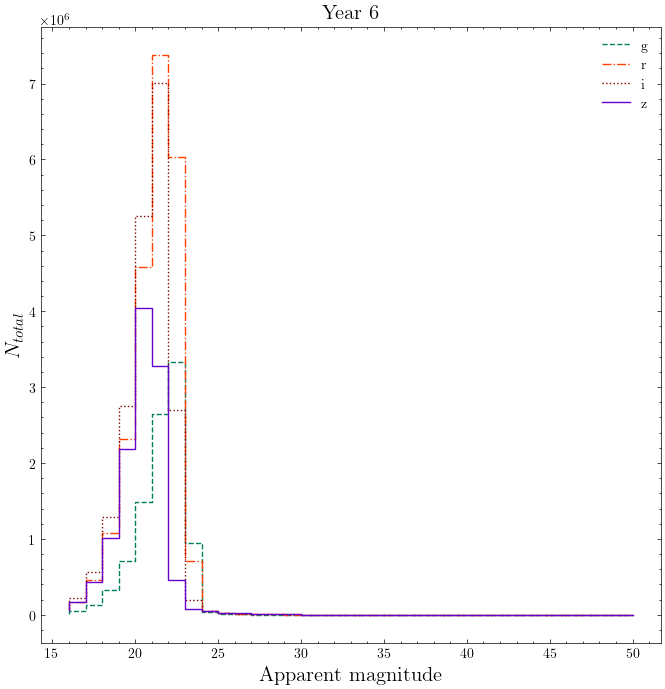

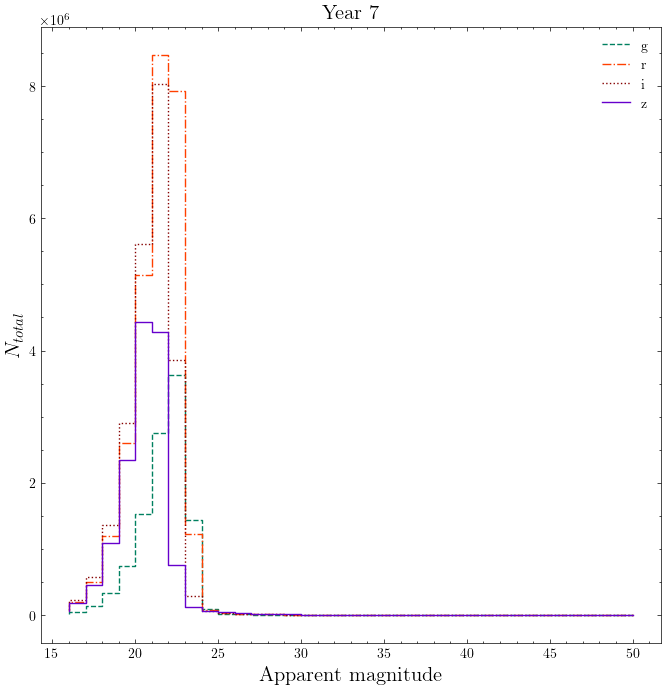

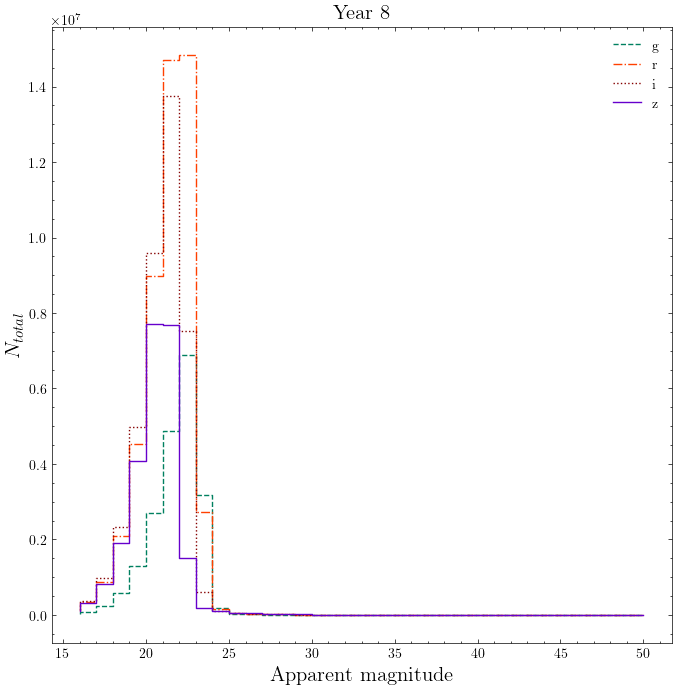

In [9]:
cols = df.columns
df_ = df.drop(columns=["bands"])
xlabels = [int(col.split("bin")[1]) for col in df_.columns]

for i, _ in enumerate(years):
    plt.figure(figsize=(8,8))
    for filt in filters:
        plt.step(xlabels, df_[df["bands"] == filt].iloc[i], c=filter_colors[filt], label=filt, linestyle=linestyles[filt])
        plt.legend()
        plt.xlabel("Apparent magnitude", fontsize=15)
        plt.ylabel(r"$N_{total}$", fontsize=15)
        plt.title(f"Year {i}", fontsize=15)
    plt.show()

Cummulative magnitude distributions

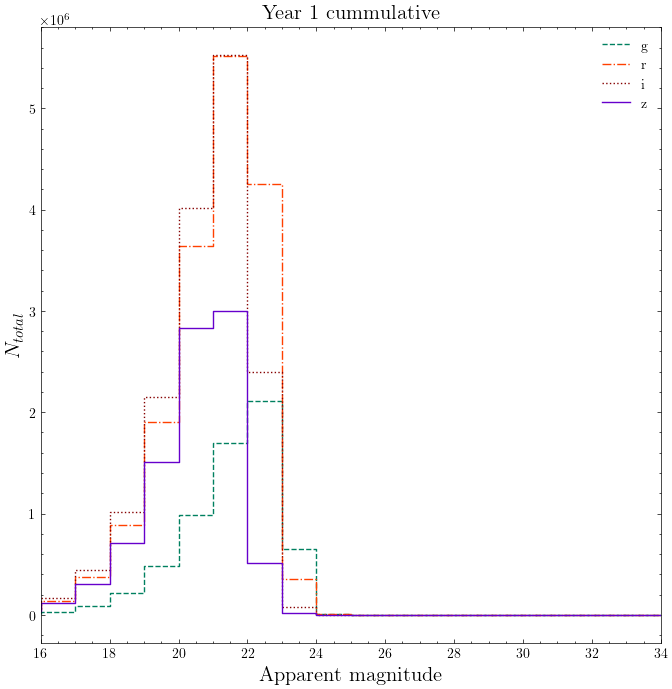

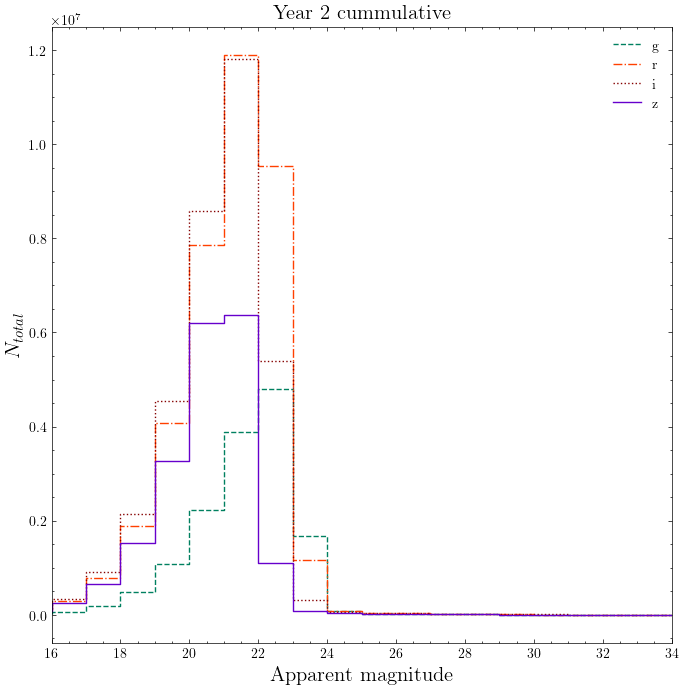

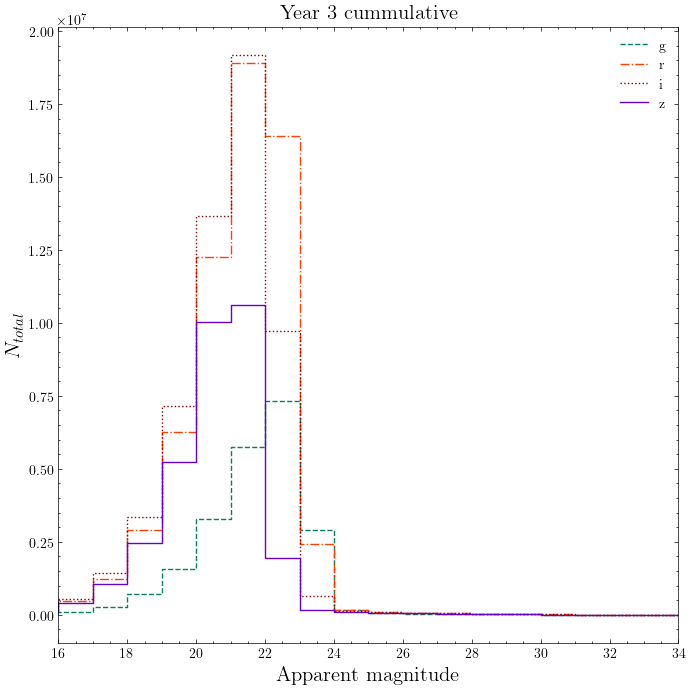

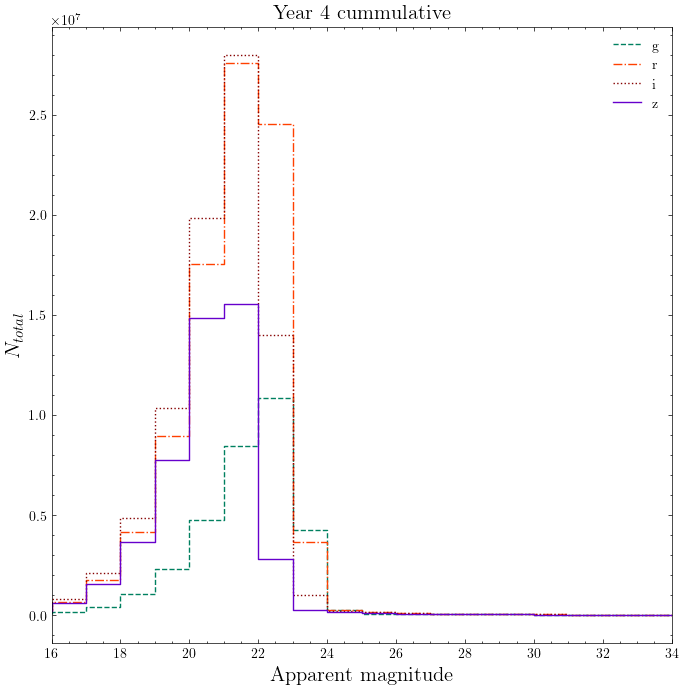

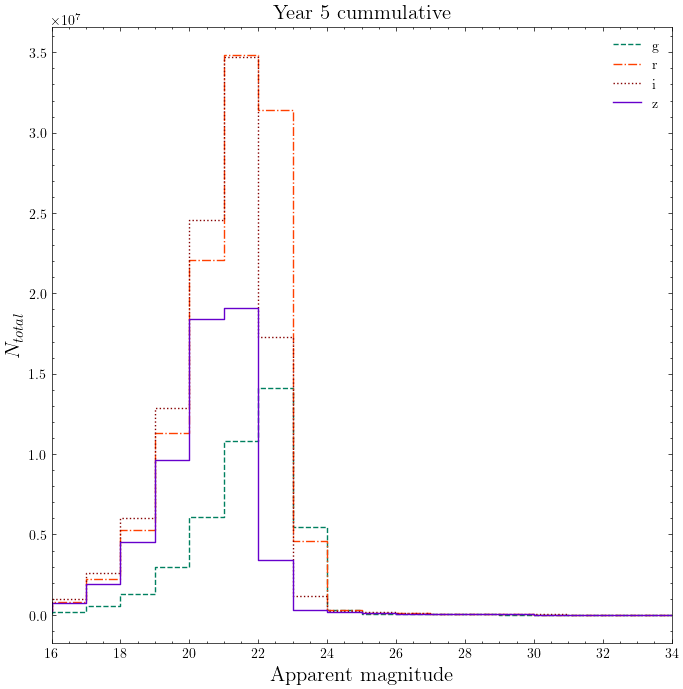

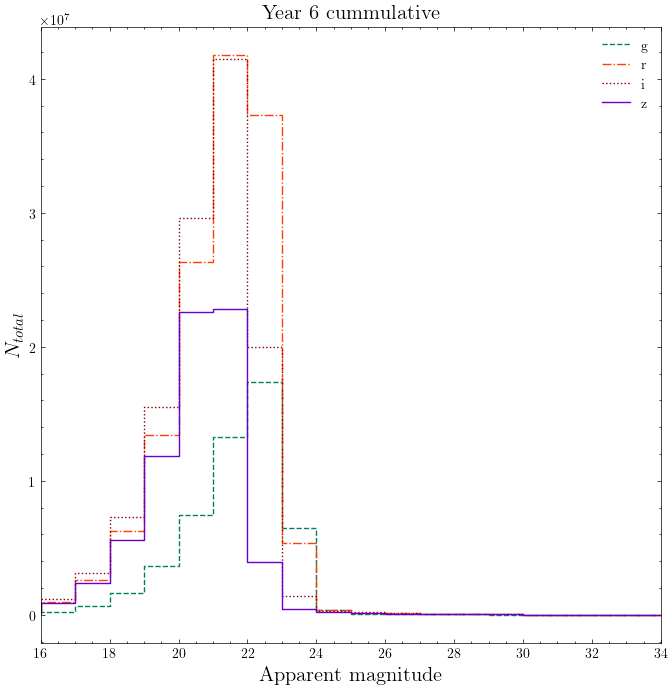

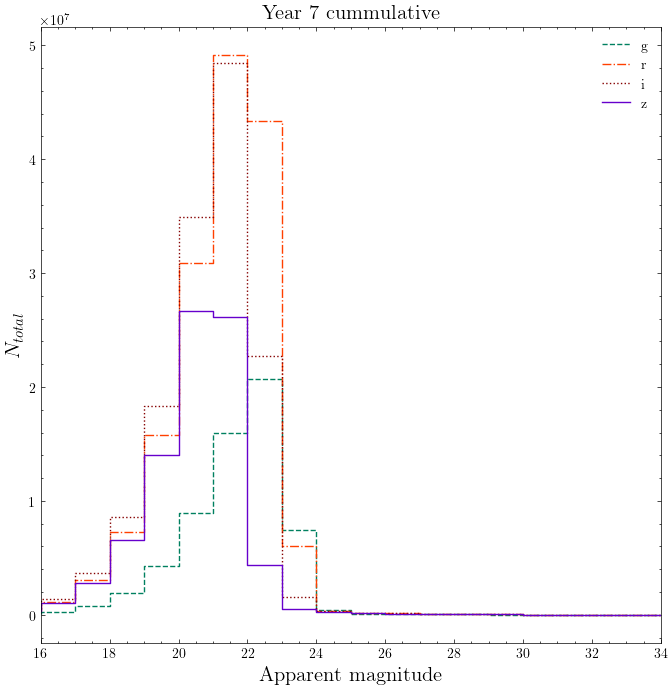

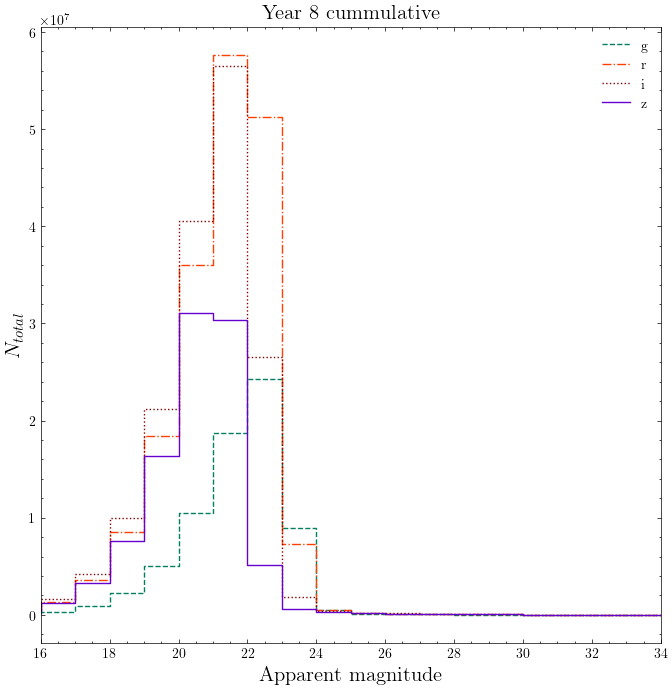

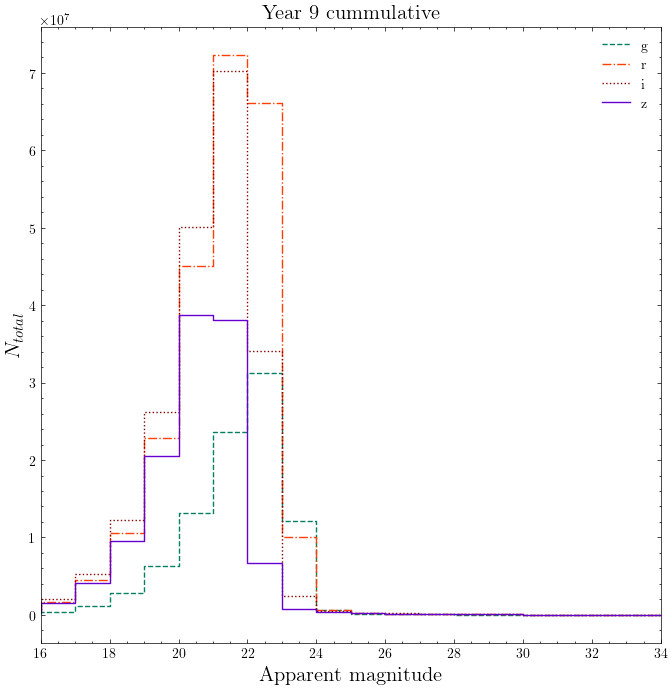

In [10]:
for i in range(1, len(years) + 1, 1):
    plt.figure(figsize=(8,8))
    for filt in filters:
        plt.step(xlabels, df_[df["bands"] == filt].iloc[0:i].sum() , c=filter_colors[filt], label=filt, linestyle=linestyles[filt])
        plt.legend()
        plt.xlabel("Apparent magnitude", fontsize=15)
        plt.ylabel(r"$N_{total}$", fontsize=15)
        plt.title(f"Year {i} cummulative", fontsize=15)
        plt.xlim(16,34)
    plt.show()

"Wonky" magnitudes

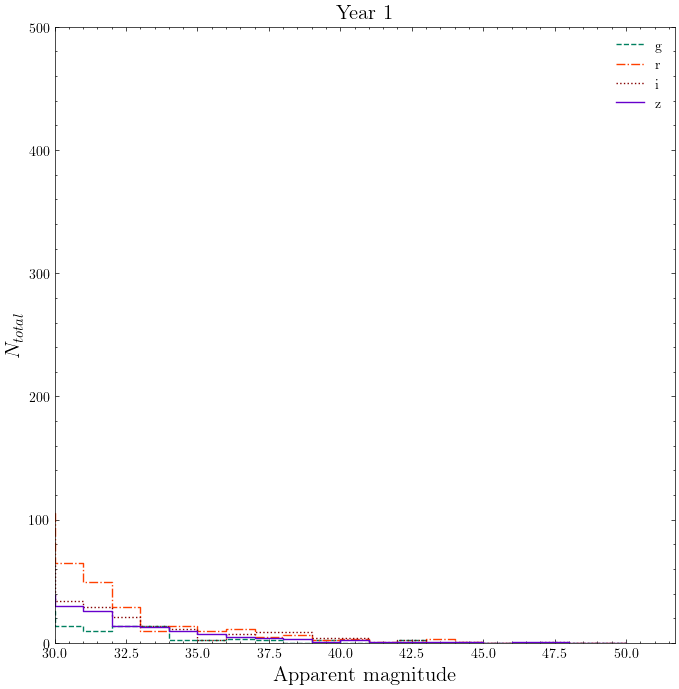

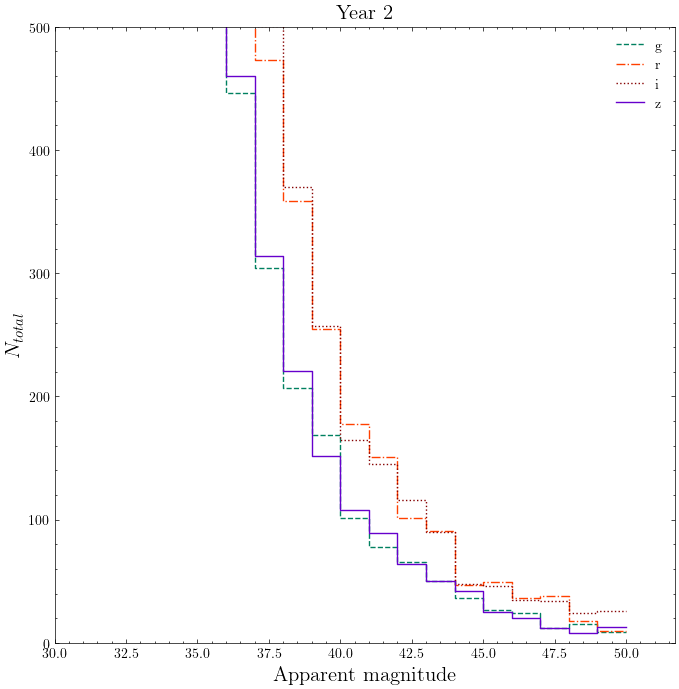

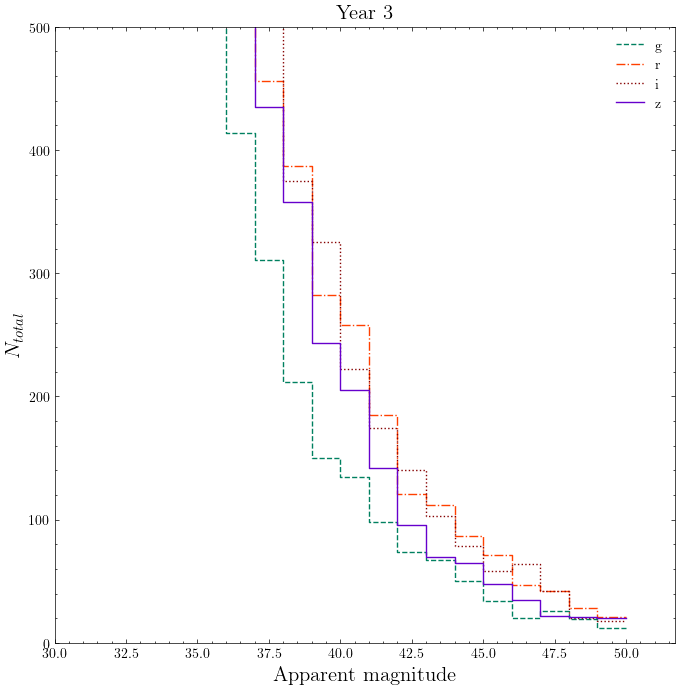

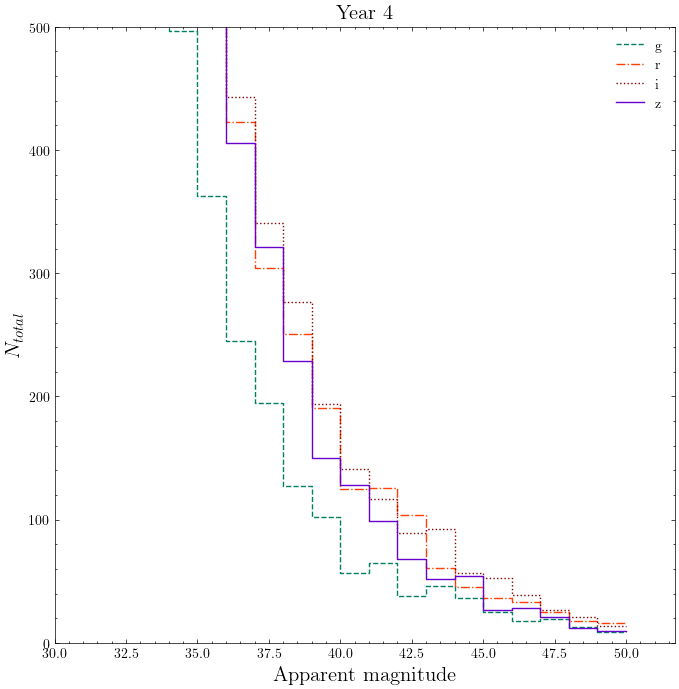

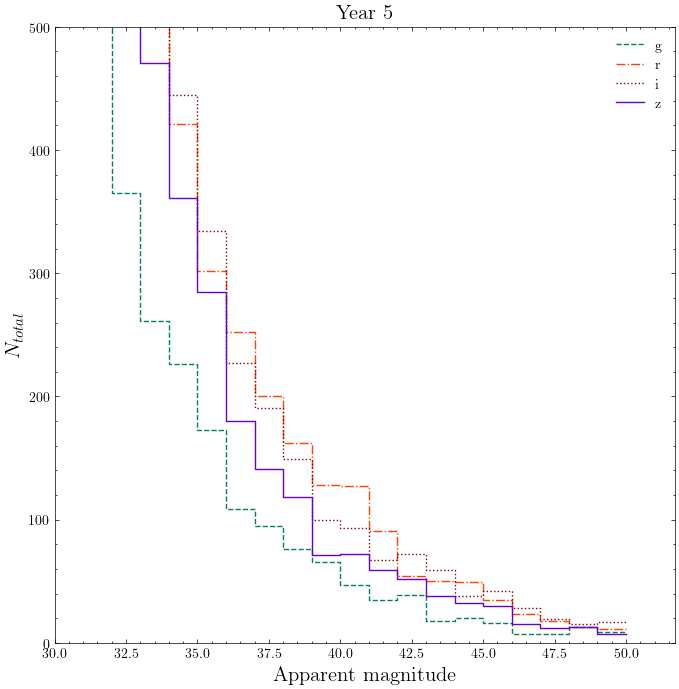

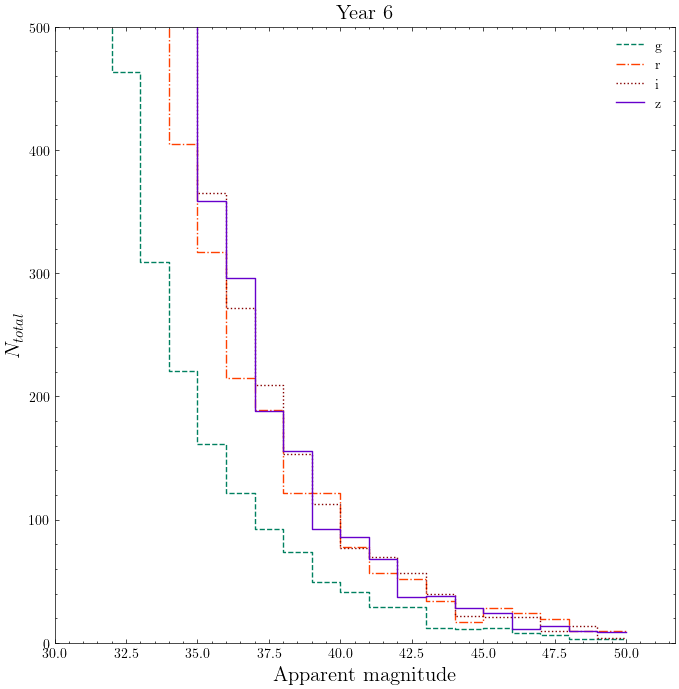

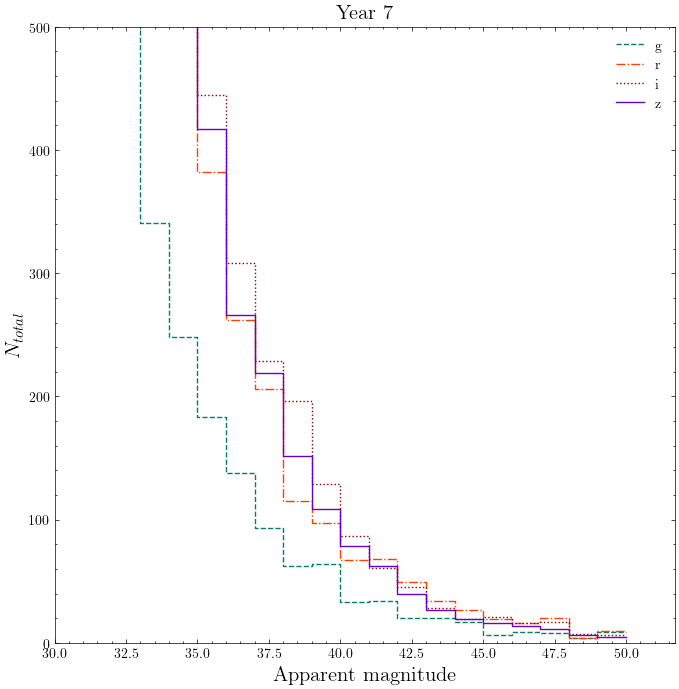

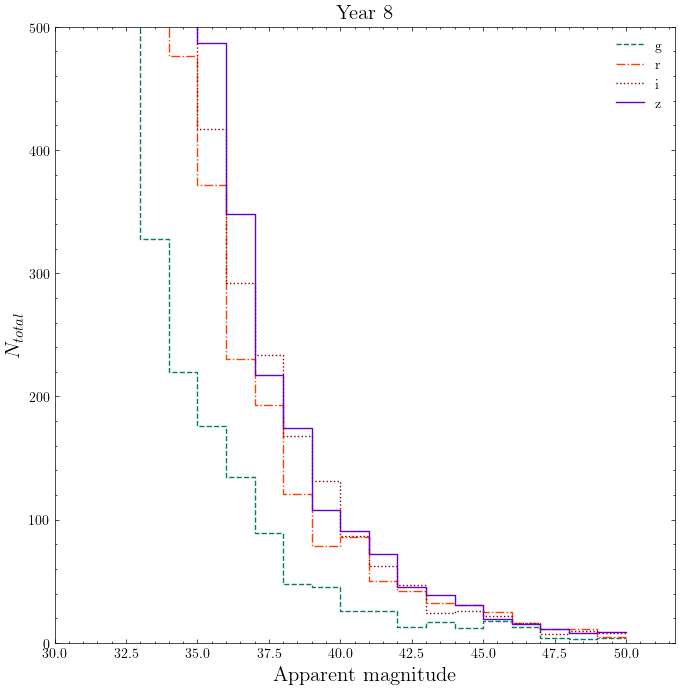

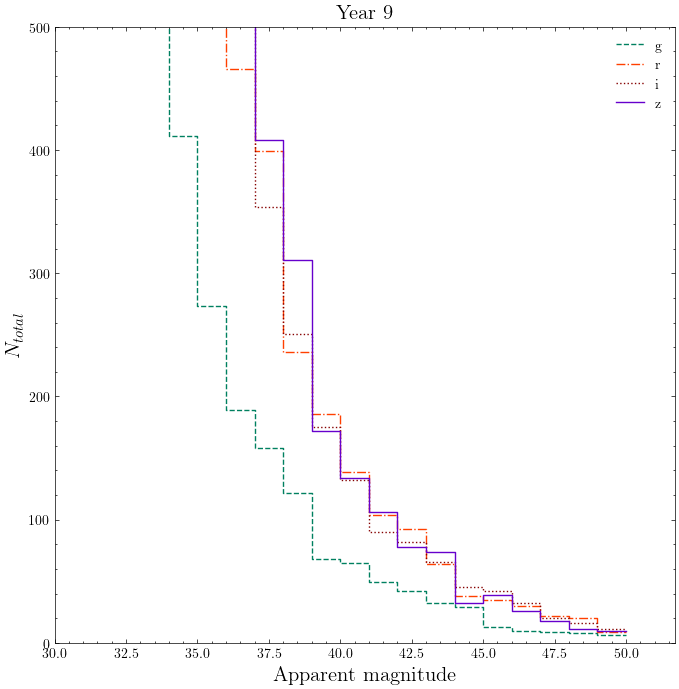

In [14]:
cols = df.columns
df_ = df.drop(columns=["bands"])
xlabels = [int(col.split("bin")[1]) for col in df_.columns]

for i, _ in enumerate(years):
    plt.figure(figsize=(8,8))
    for filt in filters:
        plt.step(xlabels, df_[df["bands"] == filt].iloc[i], c=filter_colors[filt], label=filt, linestyle=linestyles[filt])
        plt.legend()
        plt.xlabel("Apparent magnitude", fontsize=15)
        plt.ylabel(r"$N_{total}$", fontsize=15)
        plt.title(f"Year {i + 1}", fontsize=15)
        plt.xlim(30, )
        plt.ylim(0, 500)
    plt.show()